In [1]:
import math

import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPYNBrenderer import render_google_doc
from tensorflow import keras
import tensorflow as tf
cf.go_offline(connected=True)

2022-10-23 01:42:43.900867: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


$$ \ m_{current} = \beta m + \eta \frac{\partial c}{\partial w _{((w=wcurrent)+ \beta m)}}

$$ \ w_{new} = w_{current} - m_{current}

In [2]:
def MSE_loss(target_y, predicted_y):
  error = target_y - predicted_y
  squared_error = tf.square(error)
  mse = tf.reduce_mean(squared_error)
  return mse

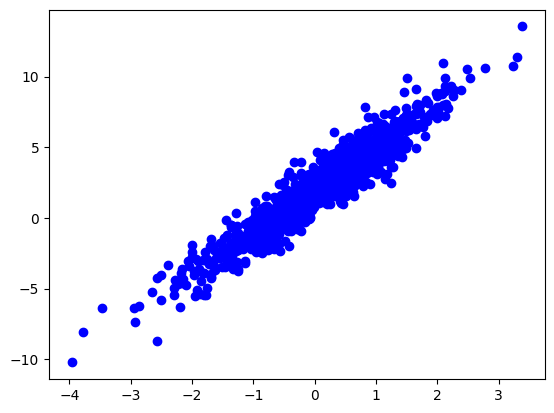

In [3]:
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000


x = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
y = x * TRUE_W + TRUE_B + noise

plt.scatter(x, y, c='b')

In [22]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # initial weights
    self.w = tf.Variable(5.0) # TRUE_W = 3.0
    self.b = tf.Variable(0.0) # TRUE_B = 2.0
    self.w_m = tf.Variable(0.0)
    self.b_m =  tf.Variable(0.0)

  def __call__(self, x):
    return (self.w*x + self.b) , ((self.w_m+self.w)*x + (self.b+self.b_m))

In [5]:
model = MyModel()

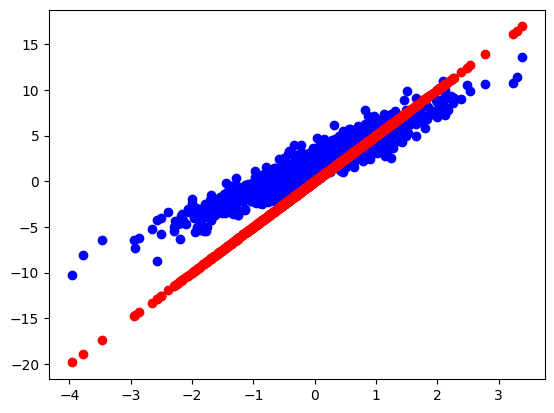

In [6]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y, c="r")

plt.show()


In [26]:
def nag_optimizer_train(model, x, y, learning_rate , momentum):

  with tf.GradientTape(persistent=True) as tape:
    y_hat , y_future = model(x)
    current_loss = MSE_loss(y, y_hat)
    future_loss = MSE_loss(y, y_future)

  dc_dw, dc_db = tape.gradient(current_loss, [model.w, model.b])
  df_dw, df_db = tape.gradient(future_loss, [(model.w_m+model.w), (model.b+model.b_m)])
  mw_new = momentum * model.w_m + learning_rate * dc_dw
  mb_new = momentum * model.b_m + learning_rate * dc_db

  model.w.assign_sub(mw_new) # w = w - n * grad => w -= n*grad_w
  model.b.assign_sub(mb_new) # b = b - n * grad => b -= n*grad_b
  model.b_m.assign(mb_new)
  model.w_m.assign(mw_new)
  return current_loss

In [27]:
model = MyModel()

Ws, bs , mw , mb  = list(), list() , list() , list()
LOSS = list()
epochs = 20

learning_rate = 0.9 # LARGE LEARNING RATE

w = model.w.numpy()
b = model.b.numpy()

init_loss = MSE_loss(y, model(x)).numpy()

print(f"initial W: {w}, initial_bias: {b}, initial loss: {init_loss}")

initial W: 5.0, initial_bias: 0.0, initial loss: 8.675335884094238


In [28]:
for epoch in range(epochs):
  nag_optimizer_train(model, x, y, learning_rate , momentum = 0.9)

  Ws.append(model.w.numpy())
  bs.append(model.b.numpy())
  mw.append(model.w_m.numpy())
  mb.append(model.b_m.numpy())
  current_loss = MSE_loss(y, model(x))
  LOSS.append(current_loss.numpy())

  print(f"For epoch: {epoch}, W: {Ws[-1]}, initial_bias: {bs[-1]}, current loss: {current_loss}")

For epoch: 0, W: 1.432058572769165, initial_bias: 3.3505587577819824, current loss: 6.888955116271973
For epoch: 1, W: 0.9498367309570312, initial_bias: 4.041424751281738, current loss: 7.066123008728027
For epoch: 2, W: 4.072072982788086, initial_bias: 1.1430978775024414, current loss: 5.924474716186523
For epoch: 3, W: 4.924696922302246, initial_bias: -0.07987654209136963, current loss: 5.753176689147949
For epoch: 4, W: 2.27203369140625, initial_bias: 2.3212928771972656, current loss: 5.138141632080078
For epoch: 5, W: 1.155116319656372, initial_bias: 3.926621198654175, current loss: 4.706399917602539
For epoch: 6, W: 3.336064577102661, initial_bias: 2.0374855995178223, current loss: 4.4757819175720215
For epoch: 7, W: 4.620204448699951, initial_bias: 0.18628299236297607, current loss: 3.8899736404418945
For epoch: 8, W: 2.8952600955963135, initial_bias: 1.5733249187469482, current loss: 3.9041991233825684
For epoch: 9, W: 1.529617428779602, initial_bias: 3.5501303672790527, current

In [29]:
data = pd.DataFrame({"W": Ws, "b": bs, "mw": mw, "mb": mb})

In [30]:
data["w_true"] = TRUE_W
data["b_true"] = TRUE_B

In [43]:
data['epoch'] = range(epochs)
data['loss'] = LOSS

In [52]:
data.iplot(kind="scatter" , x="epoch", y=["W" , "b" , "w_true" , "b_true"], mode="lines+markers", title="W vs epoch")

In [51]:
data.iplot(kind="scatter" , x="epoch", y=["loss", "W" , "b" ], mode="lines+markers", title="W vs epoch")

In [55]:
x.shape , y.shape

(TensorShape([1000]), TensorShape([1000]))

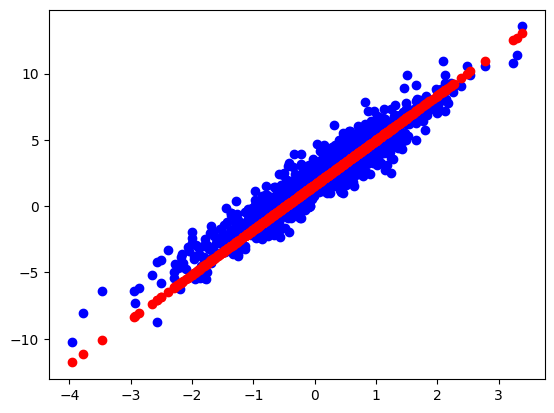

In [58]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y[0], c="r")

plt.show()

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full
X_test = X_test 
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
%%timeit
LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Dense(10, activation="softmax")]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss',restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard("tensor_board_logs")
model_normalized_batch= tf.keras.models.Sequential(LAYERS)
model_normalized_batch.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=1e-3 , momentum=0.9 ,nesterov=True), metrics=["accuracy"])
history = model_normalized_batch.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30


2022-10-23 01:02:11.803484: E tensorflow/stream_executor/cuda/cuda_blas.cc:218] failed to create cublas handle: cublas error
2022-10-23 01:02:11.803519: E tensorflow/stream_executor/cuda/cuda_blas.cc:220] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.


InternalError: Graph execution error:

Detected at node 'sequential/dense_3/MatMul' defined at (most recent call last):
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_43836/1880157373.py", line 1, in <module>
      get_ipython().run_cell_magic('timeit', '', 'LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),\n    tf.keras.layers.LeakyReLU(),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),\n    tf.keras.layers.LeakyReLU(),\n    \n    tf.keras.layers.Dense(10, activation="softmax")]\nearly_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor=\'val_loss\',restore_best_weights=True)\ntensorboard_cb = tf.keras.callbacks.TensorBoard("tensor_board_logs")\nmodel_normalized_batch= tf.keras.models.Sequential(LAYERS)\nmodel_normalized_batch.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=1e-3 , momentum=0.9), metrics=["accuracy"])\nhistory = model_normalized_batch.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])\n')
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2362, in run_cell_magic
      result = fn(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 1162, in timeit
      time_number = timer.timeit(number)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 156, in timeit
      timing = self.inner(it, self.timer)
    File "<magic-timeit>", line 14, in inner
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/pk/miniconda3/envs/tf_activation/lib/python3.9/site-packages/keras/layers/core/dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential/dense_3/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node sequential/dense_3/MatMul}}]] [Op:__inference_train_function_1034]

#### Drawbacks 
$ \beta$  = one more parameter to tune , even though $ \beta$ = 0.9 works fine 
oscillation when it reaches the minimum as accumulation of the past momentum  
#### Advantage 
momentum helps to coverage faster 
oscillation can help to come out of local minimum if any 